In [ ]:
import filegetter.filegetter as fgt
import pandas as pd
df = fgt.get("binance", "swap", "btc-usdt", "trade","20250318", machine="AWS-JP1")
dg = fgt.get("binance", "swap", "btc-usdt", "depth5","20250318", machine="AWS-JP1")
trades_df=df
quotes_df=dg


In [ ]:
df

,p,v,ts,local_time,upload_time,source,trade_id
0,83963.0,0.398,1742256004820,1742256004825121767,1742256004852139726,NaN,6113553678
1,83963.0,0.215,1742256004820,1742256004825126770,1742256004852139726,NaN,6113553679
2,83963.0,0.001,1742256004821,1742256004825139498,1742256004852139726,NaN,6113553680
3,83963.0,0.387,1742256004821,1742256004825142119,1742256004852139726,NaN,6113553681
4,83963.0,0.020,1742256004821,1742256004825144440,1742256004852139726,NaN,6113553682
...,...,...,...,...,...,...,...
3166246,82666.1,-0.006,1742342398268,1742342398270669824,1742342398270712758,NaN,6116788695
3166247,82666.2,0.060,1742342398412,1742342398413824483,1742342398413845542,NaN,6116788696
3166248,82666.1,-0.014,1742342398520,1742342398521849402,1742342398521855776,NaN,6116788697
3166249,82666.2,0.002,1742342398819,1742342398821287085,1742342398821292412,NaN,6116788698


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from tick.hawkes import HawkesExpKern
from scipy.stats import poisson
from numba import njit
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# ===============================================================
# 双边 + 双β(12 & 1.5) 近似双核 Hawkes  + NB 尾  + Platt 校准
# 兼容 tick 0.7.x      —— 20 ms 时间容忍度 & 20 ms 聚合粒度
# ===============================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from tick.hawkes import HawkesExpKern
from scipy.stats import nbinom
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, roc_auc_score
from numba import njit

# --------------------- 0. 载入并对齐 ---------------------------
TICK_SIZE   = 0.1
TRADES_TOL  = "20ms"      # ← 合并报价–成交的容忍度

trades_df["datetime"] = pd.to_datetime(trades_df["ts"], unit="ms")
trades_df = trades_df.set_index("datetime").sort_index()
dg["datetime"] = pd.to_datetime(dg["ts"], unit="ms")
dg = dg.set_index("datetime").sort_index()

merged = (pd.merge_asof(trades_df.reset_index(), dg.reset_index(),
                        on="datetime", direction="backward",
                        tolerance=pd.Timedelta(TRADES_TOL))
            .set_index("datetime")
            .dropna(subset=["bp1", "ap1"]))

print("merge 成功行数 =", len(merged))

merged["mid"]        = 0.5 * (merged["bp1"] + merged["ap1"])
merged["delta_tick"] = ((merged["p"] - merged["mid"]) / TICK_SIZE).round().astype(int)
merged               = merged[merged["delta_tick"] != 0]

merged = merged.resample("20ms").sum(min_count=1).dropna(subset=["p"])
print("20 ms 聚合后行数 =", len(merged))

# --- 0‑4 计算同档排队深度 q_front ------------------------------
def depth_same_row(row, max_lv=5):
    d = int(row["delta_tick"])
    lv = max(1, min(abs(d), max_lv))      # 档位号 1~5
    return row[f"bv{lv}"] if d < 0 else row[f"av{lv}"]

merged["q_front"] = merged.apply(depth_same_row, axis=1).astype(float)

# 还可选：累加前档深度（吃 bp4 必须先吃 bp1‑bp3）
def cumsum_depth(row, max_lv=5):
    d = int(row["delta_tick"])
    if d < 0:
        return sum(row[f"bv{lv}"] for lv in range(1, min(abs(d),max_lv)+1))
    else:
        return sum(row[f"av{lv}"] for lv in range(1, min(abs(d),max_lv)+1))
merged["q_front_cum"] = merged.apply(cumsum_depth, axis=1).astype(float)




merge 成功行数 = 809922
20 ms 聚合后行数 = 150741


In [ ]:
merged[["bp1","bp2","bp3","bp4","bp5","delta_tick","q_front_cum","p","mid"]][1000:1050]

,bp1,bp2,bp3,bp4,bp5,delta_tick,q_front_cum,p,mid
datetime,,,,,,,,,
2025-03-18 00:21:10.560,167862.8,167862.6,167862.4,167862.2,167861.6,2.0,15.750,167863.0,167862.90
2025-03-18 00:21:10.780,83931.4,83931.3,83931.2,83931.1,83930.8,-1.0,7.353,83931.4,83931.45
2025-03-18 00:21:10.840,83931.4,83931.3,83931.2,83931.1,83930.8,1.0,7.827,83931.5,83931.45
2025-03-18 00:21:11.640,167862.8,167862.6,167862.4,167862.2,167861.6,2.0,15.298,167863.0,167862.90
2025-03-18 00:21:14.200,83931.4,83931.3,83931.2,83931.1,83930.8,1.0,6.676,83931.5,83931.45
2025-03-18 00:21:15.320,83931.4,83931.3,83931.2,83931.1,83930.8,1.0,4.687,83931.5,83931.45
2025-03-18 00:21:15.820,83931.4,83931.3,83931.2,83931.1,83930.9,1.0,7.746,83931.5,83931.45
2025-03-18 00:21:16.500,83931.4,83931.3,83931.2,83931.1,83930.9,1.0,8.191,83931.5,83931.45
2025-03-18 00:21:16.980,83931.4,83931.3,83931.2,83931.1,83930.9,1.0,2.321,83931.5,83931.45


20 ms 聚合后行数 = 150741
买单事件 81118, 卖单事件 69462
[buy ] μ=0.530, α1=0.220, α2=0.647
[sell] μ=0.463, α1=0.225, α2=0.622


/home/luchen/filegetter-1/.venv/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:336: RuntimeWarning: divide by zero encountered in _nbinom_cdf
  return _boost._nbinom_cdf(k, n, p)


采样点 = 150741
    q_my    T       N     Brier       AUC
6    4.0  0.1  150741  0.003010  0.811157
5    3.0  0.1  150741  0.003542  0.821316
4    2.0  0.1  150741  0.004659  0.834899
3    1.0  0.1  150741  0.007059  0.855165
13   4.0  0.3  150741  0.008488  0.792832
12   3.0  0.3  150741  0.010304  0.803784
11   2.0  0.3  150741  0.013236  0.817814
20   4.0  0.5  150741  0.014168  0.797323
19   3.0  0.5  150741  0.016948  0.806181
10   1.0  0.3  150741  0.019009  0.839467
18   2.0  0.5  150741  0.021438  0.817430
27   4.0  1.0  150741  0.027811  0.793963
17   1.0  0.5  150741  0.029100  0.835276
26   3.0  1.0  150741  0.032839  0.802302
2    0.5  0.1  150741  0.035973  0.856946


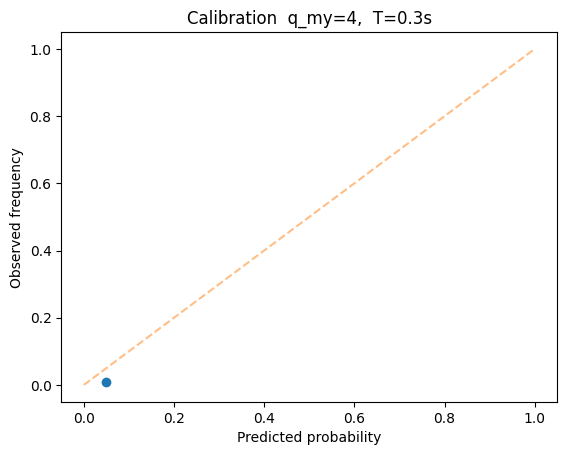

In [ ]:
# -------- 0-bis. 20 ms 聚合 ------------------------------------
merged = merged.resample("20ms").sum(min_count=1).dropna(subset=["p"])
print("20 ms 聚合后行数 =", len(merged))


# --------------------- 1. 事件拆分 ------------------------------
mask_buy  = merged["v"] > 0
mask_sell = merged["v"] < 0

# ① 把 DatetimeIndex 一次性转换成 int64（单位：纳秒）
idx_ns = merged.index.view("int64")          # ndarray[int64]
t0_sec = idx_ns[0] / 1e9                     # 基准秒

# ② 得到买 / 卖事件秒数向量
ev_buy  = (idx_ns[mask_buy ] / 1e9 - t0_sec).astype(float)
ev_sell = (idx_ns[mask_sell] / 1e9 - t0_sec).astype(float)

print(f"买单事件 {len(ev_buy)}, 卖单事件 {len(ev_sell)}")

# --------------------- 2. 双 β Hawkes 拟合 ----------------------
β_short, β_long = 12.0, 1.5        # 80 ms & 0.7 s

def fit_one_beta(events, beta_fixed):
    hk = HawkesExpKern(decays=[[beta_fixed]], max_iter=60)
    hk.fit([events])
    return hk.baseline[0], hk.adjacency[0, 0]

μ1_b, α1_b = fit_one_beta(ev_buy , β_short)
μ2_b, α2_b = fit_one_beta(ev_buy , β_long)
μb_hat     = 0.5 * (μ1_b + μ2_b)

μ1_s, α1_s = fit_one_beta(ev_sell, β_short)
μ2_s, α2_s = fit_one_beta(ev_sell, β_long)
μs_hat     = 0.5 * (μ1_s + μ2_s)

print(f"[buy ] μ={μb_hat:.3f}, α1={α1_b:.3f}, α2={α2_b:.3f}")
print(f"[sell] μ={μs_hat:.3f}, α1={α1_s:.3f}, α2={α2_s:.3f}")

# --------------------- 3. λ₀(t) 近似双核 ------------------------
@njit
def lambda_dual(events, tgrid, μ, α1, α2, β1, β2, look=3.0):
    lam = np.empty_like(tgrid)
    k = 0
    for i, tg in enumerate(tgrid):
        t = tg - t0_sec
        while k < len(events) and events[k] < t - look:
            k += 1
        acc = 0.
        for j in range(k, len(events)):
            dt = t - events[j]
            if dt <= 0: break
            acc += α1 * np.exp(-β1 * dt) + α2 * np.exp(-β2 * dt)
        lam[i] = μ + acc
    return lam

SAMPLE_MS  = "5ms"
samples    = (merged[["delta_tick", "q_front_cum"]]
              .resample(SAMPLE_MS).first().dropna())
t_grid     = samples.index.view("int64") / 1e9

λ_buy  = lambda_dual(ev_buy , t_grid, μb_hat, α1_b, α2_b, β_short, β_long)
λ_sell = lambda_dual(ev_sell, t_grid, μs_hat, α1_s, α2_s, β_short, β_long)
λ0     = np.where(samples["delta_tick"].to_numpy() > 0, λ_buy, λ_sell)

# --------------------- 4. Λ(T) + NB 尾概率 ----------------------
q_my_list = [0.1, 0.3, 0.5, 1, 2, 3, 4]
T_list    = [0.1, 0.3, 0.5, 1, 2, 3, 4]
κ         = 1.8

L0    = λ0[:, None]
T_arr = np.array(T_list)[None, :]
Λ     = μb_hat * T_arr + (L0 - μb_hat) * (1 - np.exp(-β_long * T_arr)) / β_long

need = samples["q_front_cum"].to_numpy()[:, None] + np.array(q_my_list)[None, :]

def nb_tail(n, Lam, kappa):
    Lam   = np.maximum(Lam, 1e-12)
    kappa = max(kappa, 1.0001)
    r, p  = Lam / (kappa - 1), 1 / kappa
    return 1 - nbinom.cdf(n - 1, r, p)

P_raw = nb_tail(need[:, None, :], Λ[:, :, None], κ)

# --------------------- 5. label --------------------------------
cumvol   = np.concatenate(([0.], np.cumsum(merged["v"].abs())))
evt_time = merged.index.view("int64") / 1e9 - t0_sec

def fills(T):
    right = np.searchsorted(evt_time, (t_grid - t0_sec) + T, "right")
    left  = np.searchsorted(evt_time, (t_grid - t0_sec),       "right")
    return cumvol[right] - cumvol[left]

fills_mat = np.vstack([fills(T) for T in T_list]).T
label     = fills_mat[:, :, None] >= need[:, None, :]

# --------------------- 6. Platt 校准 ---------------------------
mask  = ~np.isnan(P_raw)
X     = P_raw[mask].reshape(-1, 1)
platt = LogisticRegression(C=1e6, max_iter=400).fit(X, label[mask])

P_cal         = np.full_like(P_raw, np.nan)
P_cal[mask]   = platt.predict_proba(X)[:, 1]

# --------------------- 7. 回测指标 ------------------------------
records = []
for j, T in enumerate(T_list):
    for k, q in enumerate(q_my_list):
        p, y = P_cal[:, j, k], label[:, j, k]
        m    = ~np.isnan(p)
        if m.sum() < 500 or y[m].astype(int).ptp() == 0:
            continue
        brier = brier_score_loss(y[m], p[m])
        auc   = roc_auc_score(y[m], p[m])
        records.append((q, T, m.sum(), brier, auc))

result = (pd.DataFrame(records, columns=["q_my", "T", "N", "Brier", "AUC"])
          .sort_values("Brier"))
print("采样点 =", len(samples))
print(result.head(15))

# --------------------- 8. 校准曲线 ------------------------------
sel_q, sel_T = 4, 0.3
j, k         = T_list.index(sel_T), q_my_list.index(sel_q)

m     = ~np.isnan(P_cal[:, j, k])
bins  = pd.cut(P_cal[m, j, k], bins=np.linspace(0, 1, 11))
cal   = pd.Series(label[m, j, k]).groupby(bins).mean()

x_mid = cal.index.map(lambda iv: iv.mid)
y_val = cal.values

plt.plot(x_mid, y_val, "o-")
plt.plot([0, 1], [0, 1], "--", alpha=.5)
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title(f"Calibration  q_my={sel_q},  T={sel_T}s")
plt.show()

In [ ]:
# ===============================================================
# 双边 + 双β Hawkes  + NB 尾概率 + Platt 校准  (20 ms 容忍&聚合版)
# 前量 q_front_cum = 20 ms 桢内 |v| ，并生成 v_lvl1…v_lvl10
# ===============================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from tick.hawkes import HawkesExpKern
from scipy.stats import nbinom
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, roc_auc_score
from numba import njit

# --------------------- 0. 载入并对齐 ---------------------------
TICK_SIZE  = 0.1
TOL        = "20ms"        # quote-trade merge 容忍度
WIN        = "20ms"        # 成交聚合窗口
SAMPLE_MS  = "5ms"         # λ(t) 采样网格

# --- 0-a 预处理：时间索引 --------------------------------------
for df in (trades_df, dg):
    df["datetime"] = pd.to_datetime(df["ts"], unit="ms")
    df.set_index("datetime", inplace=True)
    df.sort_index(inplace=True)

# --- 0-b quote × trade 合并（≤20 ms）
merged = (pd.merge_asof(trades_df.reset_index(), dg.reset_index(),
                        on="datetime", direction="backward",
                        tolerance=pd.Timedelta(TOL))
            .set_index("datetime")
            .dropna(subset=["bp1", "ap1"]))
print("after merge:", len(merged))

# --- 0-c 计算中价 & tick 差
merged["mid"]        = 0.5 * (merged["bp1"] + merged["ap1"])
merged["delta_tick"] = ((merged["p"] - merged["mid"]) / TICK_SIZE).round().astype(int)
merged = merged[merged["delta_tick"] != 0]                     # 只留主动单

# -------- 0-d 20 ms 窗口聚合 -----------------------------------
def agg_win(df_win):
    out = {}
    vol_abs = df_win["v"].abs().sum()          # 本窗总扫单量
    out["q_front_cum"] = vol_abs              # 供主流程使用

    # ▸ 额外：按 |delta_tick| 分档
    lvl = (df_win.groupby(df_win["delta_tick"].abs())
                 ["v"].agg(lambda x: x.abs().sum()))
    for k in range(1, 11):                    # 1~10 tick
        out[f"v_lvl{k}"] = lvl.get(k, 0.0)
    return pd.Series(out)

merged = merged.resample(WIN).apply(agg_win).dropna(subset=["q_front_cum"])
print("after 20 ms aggregation:", len(merged))

# --------------------- 1. 事件拆分 ------------------------------
mask_buy  = merged["delta_tick"] > 0
mask_sell = merged["delta_tick"] < 0

idx_ns = merged.index.view("int64")
t0_sec = idx_ns[0] / 1e9

ev_buy  = (idx_ns[mask_buy ] / 1e9 - t0_sec).astype(float)
ev_sell = (idx_ns[mask_sell] / 1e9 - t0_sec).astype(float)
print(f"buy events {len(ev_buy)}, sell events {len(ev_sell)}")

# --------------------- 2. 双 β Hawkes 拟合 ----------------------
β_short, β_long = 12.0, 1.5
def fit_one_beta(events, beta_fixed):
    hk = HawkesExpKern(decays=[[beta_fixed]], max_iter=60)
    hk.fit([events])
    return hk.baseline[0], hk.adjacency[0, 0]

μ1_b, α1_b = fit_one_beta(ev_buy , β_short)
μ2_b, α2_b = fit_one_beta(ev_buy , β_long)
μb_hat     = 0.5 * (μ1_b + μ2_b)

μ1_s, α1_s = fit_one_beta(ev_sell, β_short)
μ2_s, α2_s = fit_one_beta(ev_sell, β_long)
μs_hat     = 0.5 * (μ1_s + μ2_s)

print(f"[buy ] μ={μb_hat:.3f}, α1={α1_b:.3f}, α2={α2_b:.3f}")
print(f"[sell] μ={μs_hat:.3f}, α1={α1_s:.3f}, α2={α2_s:.3f}")

# --------------------- 3. λ₀(t) 近似双核 ------------------------
@njit
def lambda_dual(events, tgrid, μ, α1, α2, β1, β2, look=3.0):
    lam = np.empty_like(tgrid)
    k = 0
    for i, tg in enumerate(tgrid):
        t = tg - t0_sec
        while k < len(events) and events[k] < t - look:
            k += 1
        acc = 0.
        for j in range(k, len(events)):
            dt = t - events[j]
            if dt <= 0: break
            acc += α1 * np.exp(-β1 * dt) + α2 * np.exp(-β2 * dt)
        lam[i] = μ + acc
    return lam

samples = merged[["delta_tick", "q_front_cum"]].resample(SAMPLE_MS).first().dropna()
t_grid  = samples.index.view("int64") / 1e9

λ_buy  = lambda_dual(ev_buy , t_grid, μb_hat, α1_b, α2_b, β_short, β_long)
λ_sell = lambda_dual(ev_sell, t_grid, μs_hat, α1_s, α2_s, β_short, β_long)
λ0     = np.where(samples["delta_tick"].to_numpy() > 0, λ_buy, λ_sell)

# --------------------- 4. Λ(T) + NB 尾概率 ----------------------
q_my_list = [0.1, 0.3, 0.5, 1, 2, 3, 4]
T_list    = [0.1, 0.3, 0.5, 1, 2, 3, 4]
κ         = 1.8

L0    = λ0[:, None]
T_arr = np.array(T_list)[None, :]
Λ     = μb_hat * T_arr + (L0 - μb_hat) * (1 - np.exp(-β_long * T_arr)) / β_long

need = samples["q_front_cum"].to_numpy()[:, None] + np.array(q_my_list)[None, :]

def nb_tail(n, Lam, kappa):
    Lam   = np.maximum(Lam, 1e-12)
    kappa = max(kappa, 1.0001)
    r, p  = Lam / (kappa - 1), 1 / kappa
    return 1 - nbinom.cdf(n - 1, r, p)

P_raw = nb_tail(need[:, None, :], Λ[:, :, None], κ)

# --------------------- 5. label --------------------------------
cumvol   = np.concatenate(([0.], np.cumsum(merged["v"].abs())))
evt_time = merged.index.view("int64") / 1e9 - t0_sec

def fills(T):
    right = np.searchsorted(evt_time, (t_grid - t0_sec) + T, "right")
    left  = np.searchsorted(evt_time, (t_grid - t0_sec),       "right")
    return cumvol[right] - cumvol[left]

fills_mat = np.vstack([fills(T) for T in T_list]).T
label     = fills_mat[:, :, None] >= need[:, None, :]

# --------------------- 6. Platt 校准 ---------------------------
mask  = ~np.isnan(P_raw)
X     = P_raw[mask].reshape(-1, 1)
platt = LogisticRegression(C=1e6, max_iter=400).fit(X, label[mask])

P_cal         = np.full_like(P_raw, np.nan)
P_cal[mask]   = platt.predict_proba(X)[:, 1]

# --------------------- 7. 回测指标 ------------------------------
records = []
for j, T in enumerate(T_list):
    for k, q in enumerate(q_my_list):
        p, y = P_cal[:, j, k], label[:, j, k]
        m    = ~np.isnan(p)
        if m.sum() < 500 or y[m].astype(int).ptp() == 0:
            continue
        records.append((q, T, m.sum(),
                        brier_score_loss(y[m], p[m]),
                        roc_auc_score(y[m], p[m])))

result = (pd.DataFrame(records, columns=["q_my", "T", "N", "Brier", "AUC"])
          .sort_values("Brier"))
print("sample points =", len(samples))
print(result.head())

# --------------------- 8. 校准曲线 ------------------------------
sel_q, sel_T = 1, 0.3
j, k = T_list.index(sel_T), q_my_list.index(sel_q)

m    = ~np.isnan(P_cal[:, j, k])
bins = pd.cut(P_cal[m, j, k], bins=np.linspace(0, 1, 11))
cal  = pd.Series(label[m, j, k]).groupby(bins).mean()

plt.plot(cal.index.map(lambda iv: iv.mid), cal.values, "o-")
plt.plot([0, 1], [0, 1], "--", alpha=.5)
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title(f"Calibration  q={sel_q},  T={sel_T}s")
plt.show()

In [19]:
"""
Improved dual-beta Hawkes + negative-binomial tail model
=======================================================
* Works with any **tick** ≥ 0.5.x  – autodetects multi-decay support
* 20 ms aggregation, 5 ms prediction grid
* Analytical expectation Λ(T) (vectorised)
* Negative-binomial queue-depletion tail
* Platt calibration + metrics helpers
Author: ChatGPT  (May 2025)
"""

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from tick.hawkes import HawkesExpKern
from scipy.stats import nbinom
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, roc_auc_score
from numba import njit

# -----------------------------
# 0.  Hyper-parameters
# -----------------------------
TICK_SIZE   = 0.1
RESAMPLE_MS = "20ms"
SAMPLE_MS   = "5ms"
TRADES_TOL  = "20ms"
BETAS       = np.array([12.0, 1.5])          # β₁≈0.08 s, β₂≈0.67 s (1/s)
LOOKBACK    = 3.0
Q_MY_LIST   = np.array([0.1, 0.3, 0.5, 1, 2, 3, 4])
T_LIST      = np.array([0.1, 0.3, 0.5, 1, 2, 3, 4])
MIN_SAMPLES = 500

# -----------------------------
# 1.  Data helpers
# -----------------------------

def load_and_merge(trades: pd.DataFrame, quotes: pd.DataFrame) -> pd.DataFrame:
    trades = trades.copy(); quotes = quotes.copy()
    trades["datetime"] = pd.to_datetime(trades["ts"], unit="ms")
    quotes["datetime"] = pd.to_datetime(quotes["ts"], unit="ms")
    trades = trades.set_index("datetime").sort_index()
    quotes = quotes.set_index("datetime").sort_index()

    merged = (pd.merge_asof(trades.reset_index(), quotes.reset_index(),
                            on="datetime", direction="backward",
                            tolerance=pd.Timedelta(TRADES_TOL))
              .set_index("datetime").dropna(subset=["bp1", "ap1"]))

    merged["mid"]        = 0.5*(merged["bp1"] + merged["ap1"])
    merged["delta_tick"] = ((merged["p"] - merged["mid"])/TICK_SIZE).round().astype(int)
    merged               = merged[merged["delta_tick"] != 0]

    agg = {"p":"last", "v":"sum", "delta_tick":"last"}
    for i in range(1,6):
        agg[f"bv{i}"] = "last"; agg[f"av{i}"] = "last"
    return merged.resample(RESAMPLE_MS).apply(agg).dropna(subset=["p"])


def queue_front(row, cumul=False, max_lv=5):
    d = int(row["delta_tick"]); lv = max(1, min(abs(d), max_lv))
    rng = range(1, lv+1) if cumul else [lv]
    side = "bv" if d < 0 else "av"
    return sum(row[f"{side}{i}"] for i in rng)

# -----------------------------
# 2.  Hawkes fitting
# -----------------------------

def _fit_multi_decay(events: np.ndarray, betas: np.ndarray):
    """Attempt joint estimation; return μ and α_l."""
    try:
        hk = HawkesExpKern(decays=[betas], max_iter=60, tol=1e-5, n_threads=1)
    except TypeError:
        hk = HawkesExpKern(decays=[betas], max_iter=60, tol=1e-5)
    hk.fit([events])
    if hk.adjacency.ndim == 3:
        return hk.baseline[0], hk.adjacency[0,0,:].copy()
    raise ValueError("multi-decay not supported – fallback")


def fit_dual_hawkes(events: np.ndarray, betas: np.ndarray):
    try:
        return _fit_multi_decay(events, betas)
    except (ValueError, RuntimeError):
        mus, alphas = [], []
        for beta in betas:
            hk = HawkesExpKern(decays=[[beta]], max_iter=60, tol=1e-5)
            hk.fit([events])
            mus.append(hk.baseline[0]); alphas.append(hk.adjacency[0,0])
        return float(np.mean(mus)), np.array(alphas)


@njit(cache=True)
def lambda_dual(events, tgrid, mu, alpha, betas, lookback):
    n_beta = betas.shape[0]
    lam = np.empty(tgrid.shape[0]); k = 0
    for i, t in enumerate(tgrid):
        while k < events.shape[0] and events[k] < t - lookback:
            k += 1
        acc = 0.
        for j in range(k, events.shape[0]):
            dt = t - events[j]
            if dt <= 0: break
            for b in range(n_beta):
                acc += alpha[b]*np.exp(-betas[b]*dt)
        lam[i] = mu + acc
    return lam

# Vectorised analytical Λ(T)

def expected_counts(lam0: np.ndarray, mu: float, alpha: np.ndarray,
                    betas: np.ndarray, T: float):
    """Return Λ for every λ₀ in lam0 (vectorised)."""
    if alpha.sum() == 0:
        return mu*T + np.zeros_like(lam0)
    factor = (1 - np.exp(-betas*T)) / betas          # shape (L,)
    term   = (lam0 - mu)[:,None] * alpha[None,:] * factor[None,:]
    return mu*T + term.sum(axis=1)

# -----------------------------
# 3.  NB tail & dataset
# -----------------------------

def nb_tail(n, Lam, kappa=1.8):
    Lam = np.maximum(Lam, 1e-12)
    r   = Lam/(kappa-1); p = 1./kappa
    return 1. - nbinom.cdf(n-1, r, p)


def build_dataset(trades_df, quotes_df, q_my_list=Q_MY_LIST, T_list=T_LIST, kappa=1.8):
    merged = load_and_merge(trades_df, quotes_df)
    merged["q_front_cum"] = merged.apply(lambda r: queue_front(r, True), axis=1)

    mask_b = merged["v"]>0; mask_s = merged["v"]<0
    idx_ns = merged.index.view("int64"); base = idx_ns[0]/1e9
    ev_b = (idx_ns[mask_b]/1e9 - base).astype(float)
    ev_s = (idx_ns[mask_s]/1e9 - base).astype(float)

    mu_b, alpha_b = fit_dual_hawkes(ev_b, BETAS)
    mu_s, alpha_s = fit_dual_hawkes(ev_s, BETAS)

    samples = merged[["delta_tick","q_front_cum"]].resample(SAMPLE_MS).first().dropna()
    t_grid  = samples.index.view("int64")/1e9 - base

    lam_b = lambda_dual(ev_b, t_grid, mu_b, alpha_b, BETAS, LOOKBACK)
    lam_s = lambda_dual(ev_s, t_grid, mu_s, alpha_s, BETAS, LOOKBACK)
    lam0  = np.where(samples["delta_tick"].to_numpy()>0, lam_b, lam_s)

    # Λ matrix (vectorised)
    Λ = np.empty((len(samples), len(T_LIST)))
    for j,T in enumerate(T_LIST):
        Λ[:,j] = np.where(samples["delta_tick"]>0,
                          expected_counts(lam0, mu_b, alpha_b, BETAS, T),
                          expected_counts(lam0, mu_s, alpha_s, BETAS, T))

    need  = samples["q_front_cum"].to_numpy()[:,None] + q_my_list[None,:]
    P_raw = nb_tail(need[:,None,:], Λ[:,:,None], kappa)

    # ----- labels -----
    evt_sec = merged.index.view("int64")/1e9 - base
    cumvol  = np.concatenate(([0.], np.cumsum(merged["v"].abs().to_numpy())))

    def fills(T):
        right = np.searchsorted(evt_sec, t_grid+T, side="right")
        left  = np.searchsorted(evt_sec, t_grid,      side="right")
        return cumvol[right]-cumvol[left]

    fills_mat = np.vstack([fills(T) for T in T_LIST]).T
    label = fills_mat[:,:,None] >= need[:,None,:]
    return samples.index, P_raw, label

# -----------------------------
# 4.  Calibration & evaluation
# -----------------------------

def platt_scaling(P_raw, label, split_ratio=0.7):
    mask = ~np.isnan(P_raw); X = P_raw[mask].reshape(-1,1); y = label[mask]
    split = int(len(X)*split_ratio)
    clf = LogisticRegression(C=1e6, max_iter=200).fit(X[:split], y[:split])
    P_cal = np.full_like(P_raw, np.nan); P_cal[mask] = clf.predict_proba(X)[:,1]
    return P_cal, clf


def evaluate(P_cal, label, q_my_list=Q_MY_LIST, T_list=T_LIST, min_samples=MIN_SAMPLES):
    rec=[]
    for j,T in enumerate(T_list):
        for k,q in enumerate(q_my_list):
            p,y = P_cal[:,j,k], label[:,j,k]
            m = ~np.isnan(p)
            if m.sum()<min_samples or y[m].astype(int).ptp()==0: continue
            rec.append((q,T,m.sum(), brier_score_loss(y[m],p[m]), roc_auc_score(y[m],p[m])))
    return pd.DataFrame(rec, columns=["q_my","T","N","Brier","AUC"]).sort_values("Brier")


def reliability_diagram(P_cal, label, sel_q=4, sel_T=0.3):
    j = np.where(np.isclose(T_LIST, sel_T))[0][0]
    k = np.where(np.isclose(Q_MY_LIST, sel_q))[0][0]
    m = ~np.isnan(P_cal[:,j,k])
    bins = pd.interval_range(0,1,periods=10)
    df = pd.DataFrame({"p":P_cal[m,j,k], "y":label[m,j,k]})
    df["bin"] = pd.cut(df["p"], bins)
    cal = df.groupby("bin")["y"].mean()
    x_mid = cal.index.map(lambda iv: iv.mid)
    plt.plot(x_mid, cal.values, "o-"); plt.plot([0,1],[0,1],"--",alpha=.5)
    plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
    plt.title(f"Calibration q={sel_q}, T={sel_T}s"); plt.show()


    q_my    T       N     Brier       AUC
6    4.0  0.1  150741  0.005831  0.785962
5    3.0  0.1  150741  0.006680  0.789592
4    2.0  0.1  150741  0.008390  0.802061
3    1.0  0.1  150741  0.012042  0.821283
13   4.0  0.3  150741  0.012983  0.777287


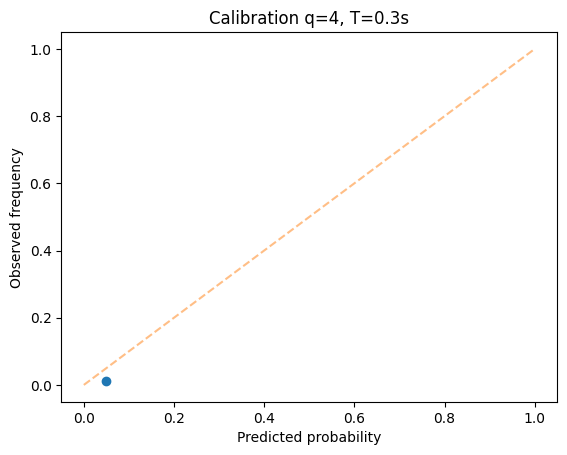

In [20]:
# 2. 生成样本集 + 原始概率
idx, P_raw, label = build_dataset(trades_df, quotes_df)

# 3. Platt 校准
P_cal, clf = platt_scaling(P_raw, label)

# 4. 评估 Brier / AUC
res_df = evaluate(P_cal, label)
print(res_df.head())

# 5. 画可靠度曲线（例：q_my = 4 lots, T = 0.3 秒）
reliability_diagram(P_cal, label, sel_q=4, sel_T=0.3)


In [45]:
# -*- coding: utf-8 -*-
"""
Queue‑Fill Probability Model — *Pure NumPy / SciPy*
===================================================
End‑to‑end implementation **without tick**:

1. Align trades & quotes → depth features (q_front_cum).
2. Fit a 2×2 Hawkes process (two fixed exponential kernels) via *least squares*.
3. Generate λ̂(t) on a 5 ms grid, integrate to Λ(t,T) for multiple horizons.
4. Compute negative‑binomial tail probability that queue ≥ need.
5. Isotonic regression calibration, Brier / LogLoss / AUC metrics.
6. Plot a calibration curve for a chosen (q,T).

Dependencies: numpy, pandas, scipy, scikit‑learn, matplotlib.
"""
from __future__ import annotations
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.signal import lfilter
from scipy.stats import nbinom
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss
from typing import List, Tuple

# ---------------------------------------------------------------------------
# CONFIGURATION --------------------------------------------------------------
# ---------------------------------------------------------------------------
TICK_SIZE   = 0.1
TRADES_TOL  = "20ms"          # merge tolerance
RESAMPLE_MS = "5ms"          # λ̂ grid
BETA_SHORT  = 12.0            # 80 ms
BETA_LONG   =  1.5            # 0.67 s
BETAS       = np.array([BETA_SHORT, BETA_LONG])

Q_MY_LIST   = [0.1, 0.3, 0.5, 1, 2, 3, 4]
T_HORIZONS  = [0.1, 0.3, 0.5, 1, 2, 3, 4]
KAPPA       = 1.8             # NB dispersion (constant)

# concave ψ parameters (optional)
KAPPA_DEFAULT = None        # set None → dynamic κ via rolling var/mean

# concave ψ parameters (optional)
# concave ψ parameters (optional)
B_CONCAVE   = 0.7
C_LIQ       = 1.0

# ---------------------------------------------------------------------------
# 0. TRADES–QUOTES ALIGNMENT --------------------------------------------------
# ---------------------------------------------------------------------------

def align_trades_quotes(trades_df: pd.DataFrame, dg: pd.DataFrame) -> pd.DataFrame:
    """Return merged DataFrame with q_front_cum depth."""
    trades_df, dg = trades_df.copy(), dg.copy()
    trades_df['datetime'] = pd.to_datetime(trades_df['ts'], unit='ms')
    dg['datetime']        = pd.to_datetime(dg['ts'], unit='ms')
    trades_df = trades_df.set_index('datetime').sort_index()
    dg        = dg.set_index('datetime').sort_index()

    merged = (pd.merge_asof(trades_df.reset_index(), dg.reset_index(),
                            on='datetime', direction='backward',
                            tolerance=pd.Timedelta(TRADES_TOL))
                .set_index('datetime')
                .dropna(subset=['bp1','ap1']))

    merged['mid']        = 0.5*(merged['bp1']+merged['ap1'])
    merged['delta_tick'] = ((merged['p']-merged['mid'])/TICK_SIZE).round().astype(int)
    merged               = merged[merged['delta_tick']!=0]

    def q_front_cum(row, max_lv: int = 5):
        d=int(row['delta_tick']); rng=range(1,min(abs(d),max_lv)+1)
        if d<0:
            return sum(row[f'bv{lv}'] for lv in rng)
        return  sum(row[f'av{lv}'] for lv in rng)

    merged['q_front_cum'] = merged.apply(q_front_cum, axis=1)
    return merged

# ---------------------------------------------------------------------------
# 1. HAWKES LEAST‑SQUARES -----------------------------------------------------
# ---------------------------------------------------------------------------

def exp_conv(events: np.ndarray, t_grid: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    """Efficient α ∑ exp(−β (t−t_j)) via scalar recurrence.

    Recurrence: h[i] = h[i−1]·exp(−β Δt_i) + α·n_i,
    where n_i = #events whose timestamp falls into interval i.
    This avoids SciPy `lfilter` which expects constant coefficients.
    """
    n = len(t_grid)
    h = np.zeros(n, dtype=float)

    # Δt between successive grid points (in seconds)
    dt = np.diff(t_grid, prepend=t_grid[0])
    decay = np.exp(-beta * dt)

    # event counts per interval
    idx = np.searchsorted(t_grid, events, side='right')
    n_i = np.bincount(idx, minlength=n)

    for i in range(1, n):
        h[i] = h[i-1] * decay[i] + alpha * n_i[i]
    # first point just α·n_0 (h[0] already 0)
    h[0] = alpha * n_i[0]
    return h


def hawkes_ls(events_list: List[np.ndarray], betas: np.ndarray, t_grid: np.ndarray,
              ema_gamma: float = 0.1) -> Tuple[np.ndarray, np.ndarray]:
    """Least‑squares estimate of (μ_i, α_ij^k)."""
    n_nodes = 2
    Δ = np.diff(t_grid, prepend=t_grid[0])

    # empirical λ̂
    lam_hat = []
    for ev in events_list:
        cnt  = np.bincount(np.searchsorted(t_grid, ev, 'right'), minlength=len(t_grid))[:len(t_grid)]
        rate = cnt/Δ
        lam_hat.append(lfilter([ema_gamma], [1, -(1-ema_gamma)], rate))
    lam_hat = np.vstack(lam_hat)                 # (2,len)

    # design matrix per source/beta
    X_cols = []
    for ev in events_list:
        for beta in betas:
            X_cols.append(exp_conv(ev, t_grid, 1.0, beta))
    X = np.vstack(X_cols).T                      # (len,4)

    # block‑diag replicate for each target
    X_big = np.zeros((len(t_grid)*n_nodes, X.shape[1]))
    X_big[0::2] = X; X_big[1::2] = X
    X_big = np.hstack([np.ones((X_big.shape[0],1)), X_big])  # intercept

    Y = lam_hat.T.ravel()
    coef, *_ = np.linalg.lstsq(X_big, Y, rcond=None)
    μ = np.array([coef[0], coef[0]])
    α = coef[1:].reshape(n_nodes, n_nodes, len(betas))
    return μ, α


def intensity_grid(μ: np.ndarray, α: np.ndarray, betas: np.ndarray,
                    events_list: List[np.ndarray], t_grid: np.ndarray) -> np.ndarray:
    n_nodes = 2
    lam = np.zeros((n_nodes, len(t_grid))) + μ[:,None]
    for i in range(n_nodes):
        for j, ev in enumerate(events_list):
            for k, beta in enumerate(betas):
                lam[i] += exp_conv(ev, t_grid, α[i,j,k], beta)
    return lam

# ---------------------------------------------------------------------------
# 2. ψ(t,q) — concave impact (optional) -------------------------------------
# ---------------------------------------------------------------------------

def concave_psi(ofi: np.ndarray, q: float,
                b: float=B_CONCAVE, c: float=C_LIQ, alpha_unit: float=1.0) -> np.ndarray:
    s = np.sign(q)
    return s*b*np.log1p(c*abs(q)*np.exp(s*ofi/(b*alpha_unit)))

# ---------------------------------------------------------------------------
# 3. NB TAIL & CALIBRATION ---------------------------------------------------
# ---------------------------------------------------------------------------

def nb_tail(n: np.ndarray, Lam: np.ndarray, kappa: float|np.ndarray) -> np.ndarray:
    Lam=np.maximum(Lam,1e-12); kappa=np.maximum(kappa,1.0001)
    r=Lam/(kappa-1); p=1/kappa
    return nbinom.sf(n-1, r, p)


def iso_calibrate(p_raw: np.ndarray, y: np.ndarray)->np.ndarray:
    mask=~np.isnan(p_raw)
    iso=IsotonicRegression(out_of_bounds='clip').fit(p_raw[mask],y[mask])
    p_cal=np.full_like(p_raw,np.nan,float); p_cal[mask]=iso.transform(p_raw[mask])
    return p_cal


def metric_row(p: np.ndarray, y: np.ndarray)->dict:
    m=~np.isnan(p)
    if m.sum()<200 or y[m].ptp()==0: return {}
    return {
        'N':m.sum(),
        'Brier':brier_score_loss(y[m],p[m]),
        'LogLoss':log_loss(y[m],p[m]),
        'AUC':roc_auc_score(y[m].astype(int),p[m])
    }

# ---------------------------------------------------------------------------
# 4. MAIN PIPELINE -----------------------------------------------------------
# ---------------------------------------------------------------------------

def queue_fill_model(trades_df: pd.DataFrame, dg: pd.DataFrame,
                     kappa_const: float | None = KAPPA_DEFAULT,
                     roll_window_s: float = 60.0):
    """Run full pipeline.

    If *kappa_const* is None, compute **dynamic κ(t)** = 1 + var/mean over a
    sliding window of length *roll_window_s* seconds (method‑of‑moments).
    """
    # —— 0. Merge ——
    merged = align_trades_quotes(trades_df, dg)
    print(f"Merged rows: {len(merged):,}")

    # —— 1. Event arrays ——
    idx_ns = merged.index.view('int64'); t0 = idx_ns[0]/1e9
    ev_buy  = (idx_ns[merged['v']>0]/1e9 - t0).astype(float)
    ev_sell = (idx_ns[merged['v']<0]/1e9 - t0).astype(float)
    events  = [ev_buy, ev_sell]

    # —— 2. Time grid ——
    t_grid = pd.date_range(merged.index[0], merged.index[-1], freq=RESAMPLE_MS)
    t_sec  = t_grid.view('int64')/1e9 - t0

    # —— 3. Hawkes LS ——
    μ, α = hawkes_ls(events, BETAS, t_sec)
    lam  = intensity_grid(μ, α, BETAS, events, t_sec)   # (2,len)
    lam_sum = lam.sum(axis=0)
    ofi     = lam[1]-lam[0]
    alpha_unit = α.sum()/(2*len(BETAS))

    # —— 4. κ(t) computation ——
    if kappa_const is None:
        win = int(roll_window_s*1000 // int(RESAMPLE_MS.strip('ms')))
        lam_series = pd.Series(lam_sum)
        var = lam_series.rolling(window=win, min_periods=win//2).var().to_numpy()
        mean = lam_series.rolling(window=win, min_periods=win//2).mean().to_numpy()
        kappa_vec = 1 + var/mean
        kappa_vec = np.clip(kappa_vec, 1.1, 5)
        # simple back/forward fill for edges
        isnan = np.isnan(kappa_vec)
        kappa_vec[isnan] = np.nanmedian(kappa_vec)
    else:
        kappa_vec = np.full_like(lam_sum, kappa_const)

    # —— 5. Sample DF ——
    samp = merged['q_front_cum'].reindex(t_grid, method='ffill').to_frame('q_front_cum')
    samp['lam_sum'] = lam_sum
    samp['ofi'] = ofi
    samp['kappa'] = kappa_vec

    # precompute cumulative vol for labels
    evt_sec = idx_ns/1e9 - t0
    cumvol  = np.concatenate(([0.], np.cumsum(np.abs(merged['v'].values))))

    def fills(dt: float)->np.ndarray:
        right = np.searchsorted(evt_sec, t_sec+dt, 'right')
        return cumvol[right]-cumvol[np.arange(len(t_sec))]

    fills_mat = np.vstack([fills(T) for T in T_HORIZONS]).T

    nS=len(samp); nT=len(T_HORIZONS); nQ=len(Q_MY_LIST)
    prob_raw=np.empty((nS,nT,nQ),float); prob_raw.fill(np.nan)
    labels=np.zeros_like(prob_raw,bool)

    print("Computing NB tail probabilities…")
    for j,T in enumerate(T_HORIZONS):
        Lam_T = lam_sum*T
        for k,q in enumerate(Q_MY_LIST):
            psi = concave_psi(ofi, q, B_CONCAVE, C_LIQ, alpha_unit)
            need = samp['q_front_cum'].values + q - psi/TICK_SIZE
            need = np.maximum(need, 0)
            prob_raw[:,j,k] = nb_tail(need, Lam_T, samp['kappa'].values)
            labels[:,j,k]   = fills_mat[:,j] >= (samp['q_front_cum'].values + q)

    # —— 6. Calibration ——
    prob_cal = np.full_like(prob_raw, np.nan)
    for j in range(nT):
        for k in range(nQ):
            prob_cal[:,j,k] = iso_calibrate(prob_raw[:,j,k], labels[:,j,k])

    # —— 7. Metrics ——
    rows=[]
    for j,T in enumerate(T_HORIZONS):
        for k,q in enumerate(Q_MY_LIST):
            met=metric_row(prob_cal[:,j,k], labels[:,j,k])
            if met:
                rows.append({'T':T,'q_my':q,**met})
    result_df=pd.DataFrame(rows).sort_values('Brier')
    print(result_df.head(15))

    # —— 8. Calibration plot ——
    sel_T, sel_q = 0.3, 4
    j=T_HORIZONS.index(sel_T); k=Q_MY_LIST.index(sel_q)
    m=~np.isnan(prob_cal[:,j,k])
    bins=pd.qcut(prob_cal[m,j,k],10,duplicates='drop')
    calib=pd.Series(labels[m,j,k]).groupby(bins).mean()
    plt.figure(figsize=(4,4))
    plt.plot(calib.index.map(lambda iv:iv.mid), calib.values,'o-')
    plt.plot([0,1],[0,1],'--',alpha=.4)
    plt.title(f"Calibration  q={sel_q}  T={sel_T}s")
    plt.xlabel("Predicted prob"); plt.ylabel("Observed freq"); plt.show()

    return result_df, prob_cal, labels

In [ ]:
result_df, prob_tensor, labels = queue_fill_model(trades_df, dg, kappa_const=None)